In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,minimize
from HOTRG import get_lattice_size,get_dist_torus_2D,get_dist_2D
import matplotlib as mpl
import importlib
importlib.reload(importlib.import_module('correlation_ansatzs'))
from correlation_ansatzs import high_temp_correlation,high_temp_correlation_with_noice,critical_correlation,loglog,scale_dependent_delta

%matplotlib inline

def process_data(data,m0=0,log2Size=30):
    lattice_size=get_lattice_size(nLayers=2*log2Size,spacial_dim=2)
    data['x']=data.apply(lambda row:row['x1']-row['x0'],axis=1)
    data['y']=data.apply(lambda row:row['y1']-row['y0'],axis=1)
    data['dist']=data.apply(lambda row:get_dist_torus_2D(row['x'],row['y'],lattice_size),axis=1)
    data['theta']=data.apply(lambda row:np.arctan2(row['y'],row['x']),axis=1)
    data['correlation_shifted']=data['correlation']-m0**2
    data=data.sort_values(by=['dist'])
    return data

def fitWithHuberLoss(ansatz,x,y,w=None,p0=None,epsilon=1,
                     bounds=None,
                             allow_positive_outliers=True,allow_negative_outliers=True):
    def loss(xs,ys,*p):
        dist=ys-ansatz(xs,*p)
        loss1=1/2 * dist**2 # lsq
        loss2=epsilon*(np.abs(dist)-epsilon/2) # huber
        if allow_positive_outliers:
            loss1[dist>epsilon]=loss2[dist>epsilon]
        if allow_negative_outliers:
            loss1[dist<-epsilon]=loss2[dist<-epsilon]
        return np.sum(loss1*w)
    w=w if w is not None else np.ones_like(x)
    xfit,yfit=x,y
    res=minimize(lambda p: loss(xfit,yfit,*p),p0,method='Nelder-Mead',tol=1e-6,bounds=bounds)
    p=res.x
    return p


def fit_data(ansatz,x,y,w=None,
             huber_epsilon=1e-1,
             x_min=None,x_max=None,
            y_min=None,y_max=None,
            bounds=None,allow_positive_outliers=True,allow_negative_outliers=True,
                use_loglog=True):
    x,y=np.array(x),np.array(y)
    w=np.array(w) if w is not None else np.ones_like(x)
    if x_min is not None:x,y,w=x[x>x_min],y[x>x_min],w[x>x_min]
    if x_max is not None:x,y,w=x[x<x_max],y[x<x_max],w[x<x_max]
    if y_min is not None:x,y,w=x[y>y_min],y[y>y_min],w[y>y_min]
    if y_max is not None:x,y,w=x[y<y_max],y[y<y_max],w[y<y_max]
    
    if use_loglog:
        x,y=x[x>0],y[x>0];x,y=x[y>0],y[y>0]
        print("number of data points:",len(x))
        logx,logy=np.log(x),np.log(y)
        p=tuple(ansatz.p0)
        # p,_=curve_fit(loglog(ansatz),logx,logy,w=w,p0=p,maxfev=10000)
        # print('coarse fitted parameters:',p)
        p=fitWithHuberLoss(loglog(ansatz),logx,logy,w=w,p0=p,epsilon=huber_epsilon,bounds=bounds,
                          allow_positive_outliers=allow_positive_outliers,
                          allow_negative_outliers=allow_negative_outliers)
    else:
        p=tuple(ansatz.p0)
        # p,_=curve_fit(ansatz,x,y,w=w,p0=ansatz.p0,maxfev=10000,bounds=bounds)
        p=fitWithHuberLoss(ansatz,x,y,w=w,p0=p,epsilon=huber_epsilon,bounds=bounds,
                          allow_positive_outliers=allow_positive_outliers,
                          allow_negative_outliers=allow_negative_outliers)
    print('fitted parameters:',p)
    print('fitted equation:',ansatz.eq.format(*p))
    return p,ansatz

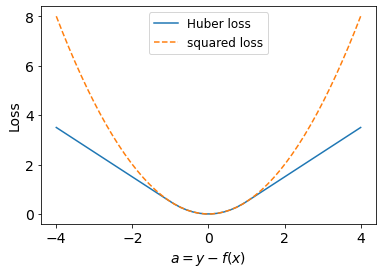

In [27]:
# plot the explination of Huber Loss

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
x=np.linspace(-4,4)
squared_loss=1/2*x**2
# huber_loss=???(np.abs(x)<1,np.abs(x)-1/2,1/2*x**2)
huber_loss=np.where(np.abs(x)>1,np.abs(x)-1/2,1/2*x**2)
plt.plot(x,huber_loss,label='Huber loss')
plt.plot(x,squared_loss,label='squared loss',linestyle='--')
plt.xlabel('$a=y-f(x)$')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./figures/HuberLoss.png',dpi=300,bbox_inches='tight')
plt.show()

# correlation below, above and at the critical point


# critical temperature
number of data points: 1000
fitted parameters: [0.69993546 0.12662825]
fitted equation: 7.00e-01x^(-2 Δ),Δ=0.1266

# high temperature
number of data points: 548
fitted parameters: [7.03268414e-01 1.69935379e+04 1.29295704e-01]
fitted equation: 7.03e-01e^(-x/ζ)/x^(2 Δ),ζ=1.70e+04,Δ=0.1293

#low temperature
m0: -0.3132449123962424
m0_double: 0.3132449123962423
number of data points: 774
fitted parameters: [6.08680417e-01 1.62256286e+03 1.65239250e-01 4.81752303e-03]
fitted equation: 6.09e-01e^(-x/ζ)/x^(2 Δ),ζ=1.62e+03,Δ=0.1652
with GILT


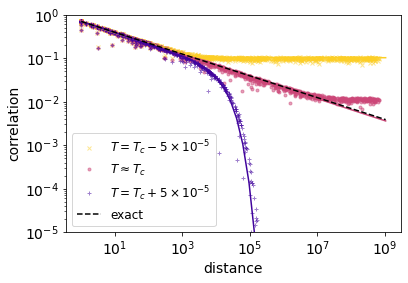

In [10]:
y_min=1e-5
huber_epsilon=1e-2

data1=pd.read_pickle('data/hotrg_gilt_X24_correlation.pkl')
data1=pd.concat([data1,pd.read_pickle('data/hotrg_gilt_X24_correlation_appended.pkl')])
data1=process_data(data1,log2Size=30)
print('\n# critical temperature')
p1,ansatz1=fit_data(critical_correlation,data1['dist'],data1['correlation'],w=np.abs(data1['correlation']),
    y_min=y_min,huber_epsilon=huber_epsilon,allow_positive_outliers=True)

print('\n# high temperature')
data2=pd.read_pickle('data/hotrg_gilt_X24_lowB_correlation.pkl')
data2=pd.concat([data2,pd.read_pickle('data/hotrg_gilt_X24_lowB_correlation_appended.pkl')])
data2=process_data(data2,log2Size=30)
high_temp_correlation.p0=(5e-1,1e3,.2)
p2,ansatz2=fit_data(high_temp_correlation,data2['dist'],data2['correlation'],w=np.abs(data2['correlation']),
    y_min=y_min,huber_epsilon=huber_epsilon,allow_positive_outliers=True)

print('\n#low temperature')
data3_obs=pd.read_csv('data/hotrg_gilt_X24_highB_observables.csv')
m0=data3_obs.iloc[-1]['magnetization']
m0_double=data3_obs.iloc[-1]['magnetization_double']
print('m0:',m0)
print('m0_double:',m0_double)
data3=pd.read_pickle('data/hotrg_gilt_X24_highB_correlation.pkl')
data3=pd.concat([data3,pd.read_pickle('data/hotrg_gilt_X24_highB_correlation_appended.pkl')])
data3=process_data(data3,m0=m0,log2Size=30)
high_temp_correlation_with_noice.p0=(5e-1,1e3,.2,.1*m0**2)
p3,ansatz3=fit_data(high_temp_correlation_with_noice,data3['dist'],data3['correlation_shifted'],w=np.abs(data3['correlation_shifted']),
   y_min=y_min,huber_epsilon=huber_epsilon,allow_positive_outliers=True)
pexp=(0.701,0.125)

print('with GILT')

ls=np.geomspace(1,2**30)
color1=plt.cm.plasma(.9)
color2=plt.cm.plasma(.5)
color3=plt.cm.plasma(.1)



plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.plot(data3['dist'],data3['correlation'],'x',label=r'$T=T_c-5\times10^{-5}$',color=color1,alpha=.5,markersize=4)
plt.plot(data1['dist'],data1['correlation'],'.',label=r'$T \approx T_c$',color=color2,alpha=.5)
plt.plot(data2['dist'],data2['correlation'],'+',label=r'$T=T_c+5\times10^{-5}$',color=color3,alpha=.5,markersize=4)
plt.plot(ls,ansatz3(ls,*p3)+m0**2,'-',color=color1)
plt.plot(ls,ansatz1(ls,*p1),'-',color=color2)
plt.plot(ls,ansatz2(ls,*p2),'-',color=color3)
plt.plot(ls,ansatz1(ls,*pexp),'--',color='black',label='exact',alpha=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlation')
plt.ylim([1e-5,1])
plt.legend()
plt.savefig('./figures/Corr.png',dpi=300,bbox_inches='tight')
plt.show()





Δ'= 0.16523924986484176
Δ(10)= 0.1249446103008162
Δ(1e-5)= 0.16464831277779657


/home/wenhan/jupyter/TRGCFT/correlation_ansatzs.py:35: RuntimeWarning: divide by zero encountered in true_divide
  return (delta+x/(2*zeta))/(1+m0**2/corr)


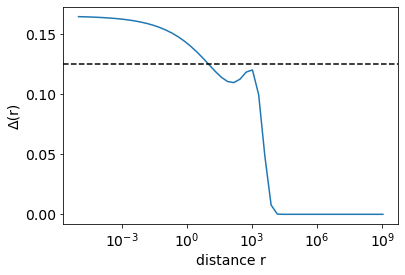

In [3]:

print("Δ'=",p3[2])
print("Δ(10)=",scale_dependent_delta(x=10,A=p3[0],zeta=p3[1],delta=p3[2],m0=m0))
print("Δ(1e-5)=",scale_dependent_delta(x=1e-5,A=p3[0],zeta=p3[1],delta=p3[2],m0=m0))

plt.figure()
ls=np.geomspace(1e-5,2**30)
plt.plot(ls,scale_dependent_delta(x=ls,A=p3[0],zeta=p3[1],delta=p3[2],m0=m0),label='Δ(x)')
plt.axhline(0.125,ls='--',color='black',label='exact')
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('distance r')
plt.ylabel('Δ(r)')
plt.show()

# y=e-x/z x^-2D +m0^2
# log(y-m0^2) vs log(e-x/z x^-2D)
# dlog(y)/dlog(x)

we have x,y

we fit ansatz from ln(y-m0) vs ln(x), we get an ansatz, it's slope in ln(y-m0) vs ln(x) is Delta'

the ansatz, if written in ln(y) vs ln(x), it's slope in ln(y) vs ln(x) is Delta

Given the ansatz, given Delta', we rewrite it in ln(y) vs ln(x), and read the corresponding Delta(x) from its slope

y=e**(-x/z)x**(-2*Dp)+m0**2

Delta(x):=d logy / d log x    # log log space

Delta'(x):=d log (y-m0^2) / d logx     #shifted log log space

sigma

sigma - m0


# Linear fitting at UV


# critical temperature
number of data points: 333
fitted parameters: [0.70148677 0.12724322]
fitted equation: 7.01e-01x^(-2 Δ),Δ=0.1272

# high temperature
number of data points: 333
fitted parameters: [0.70340262 0.12995844]
fitted equation: 7.03e-01x^(-2 Δ),Δ=0.1300

#low temperature
m0: -0.3132449123962424
number of data points: 333
fitted parameters: [0.69974641 0.12506987]
fitted equation: 7.00e-01x^(-2 Δ),Δ=0.1251
with GILT, x_max=1000


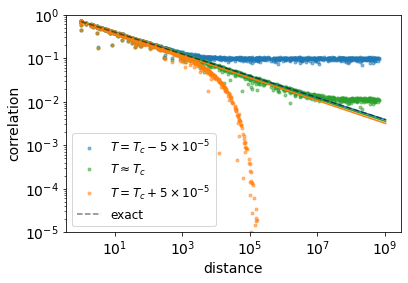

In [4]:
y_min=1e-5
x_max=10**3
huber_epsilon=1e-2

data1=pd.read_pickle('data/hotrg_gilt_X24_correlation.pkl')
data1=pd.concat([data1,pd.read_pickle('data/hotrg_gilt_X24_correlation_appended.pkl')])
data1=process_data(data1,log2Size=30)
print('\n# critical temperature')
p1,ansatz1=fit_data(critical_correlation,data1['dist'],data1['correlation'],w=np.abs(data1['correlation']),
    y_min=y_min,huber_epsilon=huber_epsilon,allow_positive_outliers=True,x_max=x_max)

print('\n# high temperature')
data2=pd.read_pickle('data/hotrg_gilt_X24_lowB_correlation.pkl')
data2=pd.concat([data2,pd.read_pickle('data/hotrg_gilt_X24_lowB_correlation_appended.pkl')])
data2=process_data(data2,log2Size=30)
p2,ansatz2=fit_data(critical_correlation,data2['dist'],data2['correlation'],w=np.abs(data2['correlation']),
    y_min=y_min,huber_epsilon=huber_epsilon,allow_positive_outliers=True,x_max=x_max)

print('\n#low temperature')
data3_obs=pd.read_csv('data/hotrg_gilt_X24_highB_observables.csv')
m0=data3_obs.iloc[-1]['magnetization']
print('m0:',m0)
data3=pd.read_pickle('data/hotrg_gilt_X24_highB_correlation.pkl')
data3=pd.concat([data3,pd.read_pickle('data/hotrg_gilt_X24_highB_correlation_appended.pkl')])
data3=process_data(data3,m0=m0,log2Size=30)
p3,ansatz3=fit_data(critical_correlation,data3['dist'],data3['correlation'],w=np.abs(data3['correlation']),
    y_min=y_min,huber_epsilon=huber_epsilon,allow_positive_outliers=True,x_max=x_max)

print('with GILT, x_max={}'.format(x_max))

ls=np.geomspace(1,2**30)

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.plot(data3['dist'],data3['correlation'],'.',label=r'$T=T_c-5\times10^{-5}$',color=color1,alpha=.5)
plt.plot(data1['dist'],data1['correlation'],'.',label=r'$T \approx T_c$',color=color2,alpha=.5)
plt.plot(data2['dist'],data2['correlation'],'.',label=r'$T=T_c+5\times10^{-5}$',color=color3,alpha=.5)
plt.plot(ls,ansatz3(ls,*p3),'-',color=color1)
plt.plot(ls,ansatz1(ls,*p1),'-',color=color2)
plt.plot(ls,ansatz2(ls,*p2),'-',color=color3)
plt.plot(ls,ansatz1(ls,*pexp),'--',color='black',label='exact',alpha=.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlation')
plt.ylim([1e-5,1])
plt.legend()


plt.show()




# comparison of different methods

- w and w/o gilt
- fix x0y0 or not

with GILT
number of data points: 100
fitted parameters: [0.69434393 0.12582566]
fitted equation: 6.94e-01x^(-2 Δ),Δ=0.1258
without GILT
number of data points: 100
fitted parameters: [0.70412991 0.12523491]
fitted equation: 7.04e-01x^(-2 Δ),Δ=0.1252
with GILT, 00
number of data points: 99
fitted parameters: [0.64299441 0.22113223]
fitted equation: 6.43e-01x^(-2 Δ),Δ=0.2211
without GILT, 00
number of data points: 99
fitted parameters: [0.66688515 0.1052466 ]
fitted equation: 6.67e-01x^(-2 Δ),Δ=0.1052


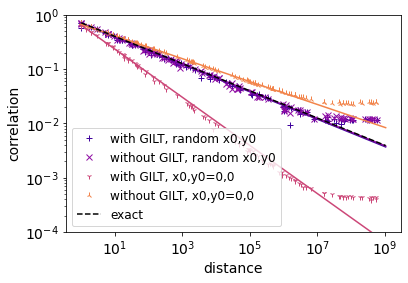

In [16]:
y_min=1e-5
huber_epsilon=1e-2

data1=pd.read_pickle('data/hotrg_gilt_X24_correlation.pkl')
data2=pd.read_pickle('data/hotrg_X24_correlation.pkl')
data3=pd.read_pickle('data/hotrg_gilt_X24_correlation_00.pkl')
data4=pd.read_pickle('data/hotrg_X24_correlation_00.pkl')


data1=process_data(data1,log2Size=30)
data2=process_data(data2,log2Size=30)
data3=process_data(data3,log2Size=30)
data4=process_data(data4,log2Size=30)


print('with GILT')
# p1,cov1,ansatz1=fit_data(data1,critical_correlation)
p1,ansatz1=fit_data(critical_correlation,data1['dist'],data1['correlation'],w=np.abs(data1['correlation']),
    y_min=y_min,huber_epsilon=huber_epsilon,allow_positive_outliers=True)

print('without GILT')
# p2,cov2,ansatz2=fit_data(data2,critical_correlation)
p2,ansatz2=fit_data(critical_correlation,data2['dist'],data2['correlation'],w=np.abs(data2['correlation']),
    y_min=y_min,huber_epsilon=huber_epsilon,allow_positive_outliers=True)

print('with GILT, 00')
# p3,cov3,ansatz3=fit_data(data3,critical_correlation)
p3,ansatz3=fit_data(critical_correlation,data3['dist'],data3['correlation'],w=np.abs(data3['correlation']),
    y_min=y_min,huber_epsilon=huber_epsilon,allow_positive_outliers=True)

print('without GILT, 00')
# p4,cov4,ansatz4=fit_data(data4,critical_correlation)
p4,ansatz4=fit_data(critical_correlation,data4['dist'],data4['correlation'],w=np.abs(data4['correlation']),
    y_min=y_min,huber_epsilon=huber_epsilon,allow_positive_outliers=True)

pexp=(0.71,0.125)

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})

ls=np.geomspace(1,2**30)

pointstyles=['+','x','1','2']
colors=plt.cm.plasma(np.linspace(.1,.7,4))

plt.plot(data1['dist'],data1['correlation'],pointstyles[0],label='with GILT, random x0,y0',color=colors[0])
plt.plot(data2['dist'],data2['correlation'],pointstyles[1],label='without GILT, random x0,y0',color=colors[1])
plt.plot(data3['dist'],data3['correlation'],pointstyles[2],label='with GILT, x0,y0=0,0',color=colors[2])
plt.plot(data4['dist'],data4['correlation'],pointstyles[3],label='without GILT, x0,y0=0,0',color=colors[3])

plt.plot(ls,ansatz1(ls,*p1),'-',color=colors[0])
plt.plot(ls,ansatz2(ls,*p2),'-',color=colors[1])
plt.plot(ls,ansatz3(ls,*p3),'-',color=colors[2])
plt.plot(ls,ansatz4(ls,*p4),'-',color=colors[3])
plt.plot(ls,ansatz4(ls,*pexp),'--',color='black',label='exact')



plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlation')
plt.ylim([1e-4,1])
plt.legend()
plt.savefig('./figures/CorrCompareGILT.png',dpi=300,bbox_inches='tight')
plt.show()


In [6]:
assert False,'stop here'

AssertionError: stop here

# Comparison of two low temp ansatzs

In [ ]:
importlib.reload(importlib.import_module('correlation_ansatzs'))
from correlation_ansatzs import get_low_temp_correlation_known_m0,low_temp_correlation_with_m0,low_temp_correlation_softmax




m0^2= 0.09812237531317773
fitted bias: 0.09940423547995059
m0^2(fit)= 0.09940423547995059

# low_temp_correlation
fitted parameters: [6.09086611e-01 1.70737530e+03 1.70813537e-01 3.13860692e-01]
fitted equation: 6.09e-01e^(-x/ζ)/x^(2 Δ)+m0^2,ζ=1.71e+03,Δ=0.1708,m0=0.314
∆(x=1)= (∆+x/(2 ζ))/(1+m0^2/corr) = 0.14727363334231464
∆(approx)= 0.14318759525115032
zeta= 1707.3752988800738 (m0^2/A)^(-1/(2delta))= 207.00980106143467 (m0^2/A)^(-1/(2deltaCFT)) 1461.573922419491

# low_temp_correlation_2
fitted parameters: [6.79377057e-01 2.45102382e+03 1.23910350e-01 7.02862086e-01]
fitted equation: 6.79e-01(ζ^(-1/B)+x^(-1/B))^(2 ∆ B),ζ=2.45e+03,∆=0.1239,B=0.7

# high_temp_correlation, biased
bias= 0.09812237531317773 ,m_0=sqrt(bias)= 0.3132449126692686
fitted parameters: [6.07541273e-01 1.42976402e+03 1.67228842e-01]
fitted equation: 6.08e-01e^(-x/ζ)/x^(2 Δ),ζ=1.43e+03,Δ=0.1672
∆(x=1)= (∆+x/(2 ζ))/(1+m0^2/corr) = 0.14426275482499035

# high_temp_correlation, no biased
fitted parameters: [6.7532718

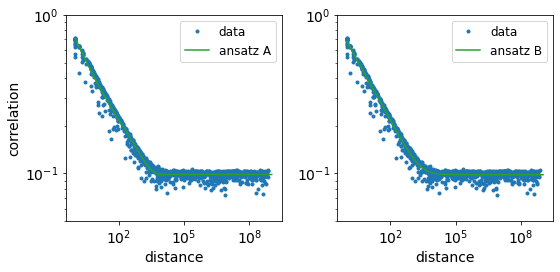

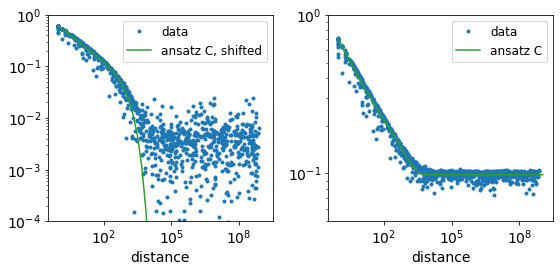

In [11]:
# compare low_temp_correlation and low_temp_correlation_1
importlib.reload(importlib.import_module('correlation_ansatzs'))
from correlation_ansatzs import low_temp_correlation,low_temp_correlation_1,low_temp_correlation_2,low_temp_correlation_3,scale_dependent_delta
def get_bias(data,cutoff_dist):
    data_slice=data[(data['dist']>cutoff_dist)]
    bias=data_slice['correlation'].median()
    print('fitted bias:',bias)
    return bias




data1=pd.read_pickle('data/hotrg_gilt_X24_highB_correlation.pkl') # low temperature
data1=pd.concat([data1,pd.read_pickle('data/hotrg_gilt_X24_highB_correlation_appended.pkl')])
data1=process_data(data1,log2Size=30)
data1_obs=pd.read_csv('data/hotrg_gilt_X24_highB_observables.csv')
m02=data1_obs.iloc[-1]['magnetization']**2
print('m0^2=',m02)
m02_fit=get_bias(data1,cutoff_dist=10**5)
print('m0^2(fit)=',m02_fit)
bias=m02

print('\n# low_temp_correlation')
p1,cov1,ansatz1=fit_data(data1,low_temp_correlation)
A,zeta,delta,m0=p1
delta_1=scale_dependent_delta(1,A,zeta,delta,m0)
delta_2=delta*(1-m0**2/A)
print('∆(x=1)=',scale_dependent_delta.eq,'=',delta_1)
print('∆(approx)=',delta_2)

print('zeta=',zeta,'(m0^2/A)^(-1/(2delta))=',np.power(m0**2/A,-1/(2*delta)),'(m0^2/A)^(-1/(2deltaCFT))',np.power(m0**2/A,-1/(2*0.125)))
print('\n# low_temp_correlation_2')
p2,cov2,ansatz2=fit_data(data1,low_temp_correlation_2)

print('\n# high_temp_correlation, biased')
print('bias=',bias,',m_0=sqrt(bias)=',np.sqrt(bias))
p3,cov3,ansatz3=fit_data(data1,high_temp_correlation,bias=bias,cutoff_dist=10**3)
A,zeta,delta=p3
delta_1=scale_dependent_delta(1,A,zeta,delta,np.sqrt(bias))
print('∆(x=1)=',scale_dependent_delta.eq,'=',delta_1)

print('\n# high_temp_correlation, no biased')
fit_data(data1,high_temp_correlation,bias=0,cutoff_dist=10**3)


print('\n# critical_correlation, biased')
fit_data(data1,critical_correlation,bias=bias,cutoff_dist=10**3)
print('\n# critical_correlation, no biased')
fit_data(data1,critical_correlation,bias=0,cutoff_dist=10**3)

ls=np.geomspace(1,2**30)

plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.subplot(121)
plt.plot(data1['dist'],data1['correlation'],'.',label=r'data',color='tab:blue')
plt.plot(ls,ansatz1(ls,*p1),'-',color='tab:green',label='ansatz A')
plt.xscale('log');plt.yscale('log');plt.ylim([5e-2,1])
plt.xlabel('distance');plt.ylabel('correlation')
plt.legend()
plt.subplot(122)
plt.plot(data1['dist'],data1['correlation'],'.',label=r'data',color='tab:blue')
plt.plot(ls,ansatz2(ls,*p2),'-',color='tab:green',label='ansatz B')
plt.xscale('log');plt.yscale('log');plt.ylim([5e-2,1])
plt.xlabel('distance')
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.subplot(121)
plt.plot(data1['dist'],np.abs(data1['correlation']-bias),'.',label=r'data',color='tab:blue')
plt.plot(ls,ansatz3(ls,*p3),'-',color='tab:green',label='ansatz C, shifted')
plt.xscale('log');plt.yscale('log');plt.ylim([1e-4,1])
plt.xlabel('distance')
plt.legend()
plt.subplot(122)
plt.plot(data1['dist'],data1['correlation'],'.',label=r'data',color='tab:blue')
plt.plot(ls,ansatz3(ls,*p3)+bias,'-',color='tab:green',label='ansatz C')
plt.xscale('log');plt.yscale('log');plt.ylim([5e-2,1])
plt.xlabel('distance')
plt.legend()
plt.tight_layout()
plt.show()
